In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.5 MB/s eta 0:00:00


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix,f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
import pandas as pd

In [ ]:
df_original = pd.read_csv('European_bank_marketing.csv')

In [ ]:
def apply_categorical_encodings(df, threshold):
  for col in df.columns:
    if pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
      unique_values = df[col].nunique()
      if unique_values <= threshold:
        one_hot_encoder = OneHotEncoder(sparse_output=False)
        encoded_col = pd.DataFrame(one_hot_encoder.fit_transform(df[[col]]))
        encoded_col.columns = [f'{col}_{val}' for val in one_hot_encoder.categories_[0]]
        df = pd.concat([df, encoded_col], axis=1)
      else:
        target_encoder = TargetEncoder()
        df[col] = target_encoder.fit_transform(df[col], df['term_deposit'])
      df.drop(col, axis=1, inplace=True)
  return df

In [ ]:
def preprocess_data(X, cat_threshold=3):
    """
    Preprocesses a dataset by encoding categorical features, transforming numerical features, scaling features,
    and removing outliers.
    
    Parameters:
        X (DataFrame): The dataset to preprocess.
        cat_threshold (int): The threshold for the number of unique values in a column to be considered categorical.
        
    Returns:
        DataFrame: The preprocessed dataset.
    """
    # Identify categorical features (including binary columns)
    cat_cols = [col for col in X.columns if pd.api.types.is_categorical_dtype(X[col]) or pd.api.types.is_object_dtype(X[col]) or (X[col].nunique() == 2)]
    # Identify numerical features
    num_cols = [col for col in X.columns if col not in cat_cols]

    # Apply categorical encodings to categorical features
    X = apply_categorical_encodings(X, cat_threshold)

    # Apply square root transformation to remove skewness
    for feat in num_cols:
        if (X[feat] > 0).all():
            X[feat] = np.sqrt(X[feat])

    # Feature scaling
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])

    # Remove outliers
    def winsorize(X, column, lower=0.05, upper=0.95):
        lower_bound = X[column].quantile(lower)
        upper_bound = X[column].quantile(upper)
        X[column] = X[column].clip(lower_bound, upper_bound)
        return X

    for feat in num_cols:
        X = winsorize(X, feat)

    return X


In [ ]:
df_preprocessed = preprocess_data(df_original, 3)

In [ ]:
df_preprocessed.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1.501339,0.010471,-0.777197,0.195414,-0.349494,0.648092,0.723197,0.886447,0.706842,0.333574,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.583994,-0.421501,-0.777197,0.195414,-0.349494,0.648092,0.723197,0.886447,0.706842,0.333574,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.238943,-0.124520,-0.777197,0.195414,-0.349494,0.648092,0.723197,0.886447,0.706842,0.333574,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.061501,-0.413787,-0.777197,0.195414,-0.349494,0.648092,0.723197,0.886447,0.706842,0.333574,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.501339,0.187888,-0.777197,0.195414,-0.349494,0.648092,0.723197,0.886447,0.706842,0.333574,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
def cross_val_logreg(data, thresholds, n_splits=5):
    
    X = data.drop('term_deposit',axis=1)
    y = data['term_deposit']
    # Define the stratified k-fold cross-validation object
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initialize empty lists to store the results for each threshold
    tpr_list = []
    fpr_list = []
    f1_list = []
    auc_list = []

    # Loop over the different threshold values
    for threshold in thresholds:
        # Initialize empty lists to store the predicted labels and true labels for each fold
        y_preds = []
        y_true_list = []
        
        # Loop over the folds
        for train_index, test_index in skf.split(X, y):
            # Split the data into training and testing sets for this fold
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Fit a logistic regression model on the training data
            model = LogisticRegression(random_state=0,solver='liblinear')
            model.fit(X_train, y_train)
            
            # Make predictions on the testing data using the given threshold
            y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)
            y_preds.append(y_pred)
            y_true_list.append(y_test)
        
        # Compute the overall TPR, FPR, F1 score, and AUC across all folds for this threshold
        y_true = np.concatenate(y_true_list)
        y_pred = np.concatenate(y_preds)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        f1_list.append(f1)
        auc_list.append(auc)
    
    # Create a pandas DataFrame to store the results
    results = pd.DataFrame({
        "Threshold": thresholds,
        "TPR": tpr_list,
        "FPR": fpr_list,
        "F1 Score": f1_list,
        "AUC": auc_list
    })
    
    return results


In [ ]:
cross_val_logreg(df_preprocessed, [0.1, 0.2, 0.35, 0.5], n_splits=5)

,Threshold,TPR,FPR,F1 Score,AUC
0,0.10,0.893966,0.166658,0.557564,0.863654
1,0.20,0.785991,0.098172,0.614232,0.843910
2,0.35,0.598707,0.053382,0.593020,0.772663
3,0.50,0.420905,0.025856,0.518175,0.697524


In [ ]:
def LogRegression(X, target_var,cat_threshold):

    # # Identify categorical features (including binary columns)
    # cat_cols = [col for col in X.columns if pd.api.types.is_categorical_dtype(X[col]) or pd.api.types.is_object_dtype(X[col]) or (X[col].nunique() == 2)]
    # # Identify numerical features
    # num_cols = [col for col in X.columns if col not in cat_cols]

    # # Apply categorical encodings to categorical features
    # X = apply_categorical_encodings(X, cat_threshold)

    # # Apply square root transformation to remove skewness
    # for feat in num_cols:
    #   if (X[feat] > 0).all():
    #       X[feat] = np.sqrt(X[feat])

    # #feature scaling
    # scaler = StandardScaler()
    # X[num_cols] = scaler.fit_transform(X[num_cols])

    # # Remove outliers
    # def winsorize(X, column, lower=0.05, upper=0.95):
    #   lower_bound = X[column].quantile(lower)
    #   upper_bound = X[column].quantile(upper)
    #   X[column] = X[column].clip(lower_bound, upper_bound)
    #   return X

    # for feat in num_cols:
    #   X = winsorize(X, feat)

    y = X[target_var]
    x = X.drop(target_var, axis=1)


    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42,stratify=y)

    log_reg = LogisticRegression(random_state=0,solver='liblinear').fit(X_train, y_train)
    
    # # Return the model, accuracy, confusion matrix, X_test, and y_test
    return log_reg, X_train, X_test, y_train, y_test

In [ ]:
model, X_train, X_test, y_train, y_test = LogRegression(df_preprocessed, 'term_deposit',3)

In [ ]:
log_reg = LogisticRegression(random_state=0, solver='liblinear')

# Train the model on the training data
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
y_train_prob = log_reg.predict_proba(X_train)

In [ ]:
y_train_logodds = np.log(y_train_prob / (1 - y_train_prob))

In [ ]:
n_components = 2
pca = PCA(n_components=n_components)

# Fit the PCA model to the log-odds data and transform the data
X_train_pca = pca.fit_transform(y_train_logodds)

In [ ]:
log_reg_pca = LogisticRegression(random_state=0, solver='liblinear')

# Train the model on the reduced-dimensionality data
log_reg_pca.fit(X_train_pca, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[10560   405]
 [  718   674]]


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print("Classification report:\n", report)

Classification report:
               precision    recall  f1-score   support

    Negative       0.94      0.96      0.95     10965
    Positive       0.62      0.48      0.55      1392

    accuracy                           0.91     12357
   macro avg       0.78      0.72      0.75     12357
weighted avg       0.90      0.91      0.90     12357



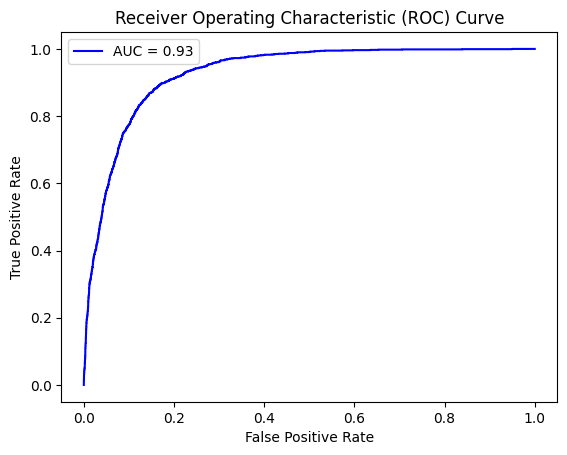

In [ ]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()
 # Plot the ROC curve
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random Guessing'))
fig.update_layout(title='Receiver Operating Characteristic (ROC) Curve',
                      xaxis_title='False Positive Rate (FPR)',
                      yaxis_title='True Positive Rate (TPR)',
                      yaxis=dict(scaleanchor="x", scaleratio=1),
                      xaxis=dict(constrain='domain'))
fig.show()

In [ ]:
def get_max_tpr(y_test, y_proba):
  dic = {}
  tpr_lst = []
  ct_lst = []
  fpr_lst = []
  f1_scores = []
  # Calculate the ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
  for i in range(len(thresholds)):
      closest_threshold = min([0.1, 0.2, 0.35, 0.5], key=lambda x:abs(x-thresholds[i]))
      ct_lst.append(closest_threshold)
      tpr_lst.append(tpr[i])
      fpr_lst.append(fpr[i])
  dic['closest_threshold'] = ct_lst
  dic['tpr'] = tpr_lst
  dic['fpr'] = fpr_lst
  df = pd.DataFrame(dic)
  max_tpr = df.groupby('closest_threshold').max()
  for threshold in max_tpr.index:
    y_pred = np.where(y_proba[:, 1] >= threshold, 1, 0)
    f1_scores.append(f1_score(y_test, y_pred))
  max_tpr['f1 score'] = f1_scores
  return max_tpr.reset_index()

In [ ]:
def logistic_regression_with_threshold(clf, X_test, y_test, threshold_list):
    
    # Predict probabilities for the testing data
    y_proba = clf.predict_proba(X_test)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_proba[:, 1])

    # Calculate the F1 score for each threshold value
    f1_scores = []
    for threshold in threshold_list:
        y_pred = np.where(y_proba[:, 1] >= threshold, 1, 0)
        f1_scores.append(f1_score(y_test, y_pred))

    # Compute the confusion matrix for the optimal threshold
    optimal_threshold = threshold_list[np.argmax(f1_scores)]
    y_pred_optimal = np.where(y_proba[:, 1] >= optimal_threshold, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()

    # Plot the ROC curve
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve'))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random Guessing'))
    fig.update_layout(title='Receiver Operating Characteristic (ROC) Curve',
                      xaxis_title='False Positive Rate (FPR)',
                      yaxis_title='True Positive Rate (TPR)',
                      yaxis=dict(scaleanchor="x", scaleratio=1),
                      xaxis=dict(constrain='domain'))
    fig.show()

    print(get_max_tpr(y_test, y_proba))
    print("AUC score: {:.2f}".format(auc_score))

    print("Confusion matrix for optimal threshold:")
    print("             Predicted No    Predicted Yes")
    print("Actual No    {:>12d}   {:>12d}".format(tn, fp))
    print("Actual Yes   {:>12d}   {:>12d}".format(fn, tp))


In [ ]:
logistic_regression_with_threshold(model, X_test, y_test, [0.1, 0.2, 0.35, 0.5])

   closest_threshold       tpr       fpr  f1 score
0               0.10  1.000000  1.000000  0.551755
1               0.20  0.840517  0.124031  0.613579
2               0.35  0.704741  0.072321  0.590877
3               0.50  0.474856  0.035021  0.503377
AUC score: 0.93
Confusion matrix for optimal threshold:
             Predicted No    Predicted Yes
Actual No            9876           1089
Actual Yes            294           1098


In [ ]:
def compute_f1_score_subgroup(data, y, subgroup_col, subgroup_val, clf):
    # Separate the subgroup data
    subgroup_mask = data[subgroup_col] == subgroup_val
    subgroup_features = data[subgroup_mask]
    subgroup_labels = pd.concat([data,y],axis=1)[subgroup_mask]["term_deposit"]

    # Make predictions on the subgroup data
    y_pred_sub = clf.predict(subgroup_features)

    # Convert the probabilities to binary predictions
    threshold = 0.2
    y_pred_sub = (y_pred_sub >= threshold).astype(int)

    # Evaluate the model's performance on the subgroup using f1 score
    f1_score_sub = f1_score(subgroup_labels, y_pred_sub)

    return f1_score_sub

In [ ]:
# Define a function to update the weights of the logistic regression model
def update_weights(X_train, y_train, lr, subgroup_col, subgroup_val, learning_rate=0.1):
    # Compute the F1 score for the given subgroup
    f1_score_sub = compute_f1_score_subgroup(X_train, y_train, subgroup_col, subgroup_val, lr)

    # Compute the bias for the given subgroup
    subgroup_mask = X_train[subgroup_col] == subgroup_val
    subgroup_size = np.sum(subgroup_mask)
    non_subgroup_size = np.sum(~subgroup_mask)
    bias = (f1_score_sub * non_subgroup_size - (1 - f1_score_sub) * subgroup_size) / (subgroup_size + non_subgroup_size)

    # Compute the gradient of the loss function w.r.t. the weights
    y_pred = lr.predict(X_train)
    error = y_pred - y_train
    gradient = np.dot(X_train.T, error) / X_train.shape[0]

    # Update the weights using the gradient and the bias
    lr.coef_ -= learning_rate * (gradient + bias)

    return lr


In [ ]:
# Adjust weights for African subgroup
model_ethical = update_weights(X_train, y_train, model, "Ethnicity_African", 0)

In [ ]:
logistic_regression_with_threshold(model_ethical, X_test, y_test, [0.1, 0.2, 0.35, 0.5])

   closest_threshold       tpr       fpr  f1 score
0               0.10  1.000000  1.000000  0.534209
1               0.20  0.856322  0.138532  0.599197
2               0.35  0.732759  0.083995  0.601118
3               0.50  0.584052  0.051801  0.545528
AUC score: 0.93
Confusion matrix for optimal threshold:
             Predicted No    Predicted Yes
Actual No           10230            735
Actual Yes            478            914
